In [1]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from PIL import Image
import random
import math
import matplotlib.pyplot as plt
import dendropy
import csv
from dendropy.calculate import treecompare
import sys
np.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


# Loading Data

In [ ]:
whole_data = np.load('./../../Data_Preprocessing/output/Big_Dataset/training_data.npy')
whole_labels_cub = np.load('./../../Data_Preprocessing/output/Big_Dataset/training_dists_cub.npy')
whole_labels_flatten = np.load('./../../Data_Preprocessing/output/Big_Dataset/training_dists_flatten.npy')

In [2]:
BRANCH_NUM = 100
SEQUENCE_LEN = 1000
OUTPUT_DIST_NUM = int((BRANCH_NUM - 1) * BRANCH_NUM / 2)

In [ ]:
whole_data.shape

In [ ]:
whole_labels_cub.shape

In [ ]:
whole_labels_flatten.shape

# Training Testing Dataset Partition

In [ ]:
print(whole_data.shape)
print(whole_labels_cub.shape)
print(whole_labels_flatten.shape)

samples_count = whole_data.shape[0]

train_size = math.floor(0.85*whole_data.shape[0])

shuffle_indices = random.sample(range(0, samples_count), samples_count)

indices_train = shuffle_indices[0:train_size]
indices_test = shuffle_indices[train_size:samples_count]

print("######## Training Data ########")
X_train = whole_data[indices_train,:]
Y_train_cub = whole_labels_cub[indices_train]
Y_train_flatten = whole_labels_flatten[indices_train]

print("######## Validation Data ########")
X_test = whole_data[indices_test,:]
Y_test_cub = whole_labels_cub[indices_test]
Y_test_flatten = whole_labels_flatten[indices_test]

print('X_train.shape : ', X_train.shape)
print('X_test.shape : ', Y_train_cub.shape)

print('Y_train_cub.shape : ', Y_train_cub.shape)
print('Y_test_cub.shape : ', Y_test_cub.shape)
print('Y_train_flatten.shape : ', Y_train_flatten.shape)
print('Y_test_flatten.shape : ', Y_test_flatten.shape)

In [ ]:
np.save('./output/X_train.npy', X_train)
np.save('./output/Y_train_cub.npy', Y_train_cub)
np.save('./output/Y_train_flatten.npy', Y_train_flatten)

np.save('./output/X_test.npy', X_test)
np.save('./output/Y_test_cub.npy', Y_test_cub)
np.save('./output/Y_test_flatten.npy', Y_test_flatten)

### Load Data

In [3]:
X_train = np.load('./output/X_train.npy')
Y_train_cub = np.load('./output/Y_train_cub.npy')
Y_train_flatten = np.load('./output/Y_train_flatten.npy')

X_test = np.load('./output/X_test.npy')
Y_test_cub = np.load('./output/Y_test_cub.npy')
Y_test_flatten = np.load('./output/Y_test_flatten.npy')

# CNN Construction

In [5]:
model = Sequential()

# Layer 1
model.add(Conv2D(10, input_shape=X_train.shape[1:], kernel_size=(3,3), strides=(1,1)))
#model.add(Conv2D(48, input_shape=(400,11,1), kernel_size=(2,2), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2
model.add(Conv2D(5, (3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3
model.add(Conv2D(5, (3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 4
model.add(Conv2D(1, (3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 5
model.add(Flatten())
model.add(Dense(OUTPUT_DIST_NUM, activation='relu'))

In [6]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 98, 998, 10)       100       
_________________________________________________________________
batch_normalization_5 (Batch (None, 98, 998, 10)       40        
_________________________________________________________________
activation_5 (Activation)    (None, 98, 998, 10)       0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 49, 499, 10)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 47, 497, 5)        455       
_________________________________________________________________
batch_normalization_6 (Batch (None, 47, 497, 5)        20        
_________________________________________________________________
activation_6 (Activation)    (None, 47, 497, 5)       

In [7]:
# (4) Compile 
#model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [8]:
loss_list_epoch = []
RF_avg_distance_epoch = []
RF_list_distance_epoch = []

### Diagonal Distance Matrix Reconstruction

In [9]:
## This function is defined for vector -> symmetric distance matrix
def utri2mat(utri):
    n = (int(-1 + np.sqrt(1 + 8*len(utri))) // 2) + 1
    iu1 = np.triu_indices(n-1)
    iu1 = (iu1[0], iu1[1] + 1)
    ret = np.zeros((n, n))
    ret[iu1] = utri
    ret.T[iu1] = utri
    return ret

In [10]:
# (5) Train
# for i in range(2):
#     print("******** Start fitting model ********")
#     history = model.fit(X_train, Y_train_flatten, validation_data=(X_test, Y_test_flatten), batch_size=20, epochs=1, verbose=1)
#     print(history.history['loss'])
#     loss_list_epoch.append(history.history['loss'][0])

#     print("******** Start calculating RF Distance ********")
#     RF_list_distance = []
#     for index in range(len(X_train)):
#         tips_num = np.count_nonzero(np.sum(X_train[index], axis=1) != 0) 
# #         print("tips_num: ", tips_num)
#         array_selection_length = int((tips_num - 1) * tips_num / 2)
#         Y_train_flatten_vec_sel = Y_train_flatten[index][0:array_selection_length]
#         X_train_results = model.predict(X_train[index].reshape((1, 100, 1000, 1)))
#         X_train_results_vec_sel = X_train_results[0][0:array_selection_length]
#         original_dis_matrix = utri2mat(Y_train_flatten_vec_sel)
#         new_dis_matrix = utri2mat(X_train_results_vec_sel)
#         for i in range(len(new_dis_matrix)):
#             new_dis_matrix[i,i] = 0
#         with open('./output/original_dis_matrix'+str(index)+'.csv', mode='w') as my_csv:
#             csvWriter = csv.writer(my_csv,delimiter=',')
#             csvWriter.writerows(original_dis_matrix)
#         with open('./output/new_dis_matrix'+str(index)+'.csv', mode='w') as my_csv:
#             csvWriter = csv.writer(my_csv,delimiter=',')
#             csvWriter.writerows(new_dis_matrix)
#         taxon_namespace = dendropy.TaxonSet()
#         pdm_origin = dendropy.PhylogeneticDistanceMatrix.from_csv(
#                 src=open('./output/original_dis_matrix'+str(index)+'.csv'),
#                 is_first_row_column_names=False,
#                 is_first_column_row_names=False,
#                 delimiter=",",
#                 taxon_namespace = taxon_namespace)
#         pdm_new = dendropy.PhylogeneticDistanceMatrix.from_csv(
#                 src=open('./output/new_dis_matrix'+str(index)+'.csv'),
#                 is_first_row_column_names=False,
#                 is_first_column_row_names=False,
#                 delimiter=",",
#                 taxon_namespace = taxon_namespace)
#         tree_origin = pdm_origin.nj_tree()
#         tree_new = pdm_new.nj_tree()
#         RF_distance = treecompare.symmetric_difference(tree_origin, tree_new)
#         RF_list_distance.append(RF_distance)
#     RF_list_distance_epoch.append(RF_list_distance)
#     RF_avg_distance_epoch.append(sum(RF_list_distance) / len(RF_list_distance))
#     print("RF_list_distance: ", RF_list_distance)
#     print("RF_avg_distance_epoch: ", RF_avg_distance_epoch)

history = model.fit(X_train, Y_train_flatten, validation_data=(X_test, Y_test_flatten), batch_size=20, epochs=1, verbose=1)
model.save('./output/CNN_model_03.h5')

Train on 24335 samples, validate on 4295 samples
Epoch 1/1
 2520/24335 [==>...........................] - ETA: 7:52 - loss: 0.0993 - accuracy: 0.0071

KeyboardInterrupt: 

In [6]:
train_result = model.evaluate(X_train, Y_train_flatten)
test_result = model.evaluate(X_test, Y_test_flatten)
print("Train Acc: ", train_result)
print("Test Acc: ", test_result)

4295/4295 [==============================] - 36s 8ms/step
Train Acc:  [0.3304489762775825, 0.0021779329981654882]
Test Acc:  [0.1497644073246383, 0.0011641443707048893]


## Load the Model

In [4]:
model = keras.models.load_model('./output/CNN_model_03.h5')

## X_train plot

In [7]:
X_train_results = model.predict(X_train)

In [8]:
train_show_index = 0

Text(0, 0.5, 'Distance Matrix Value')

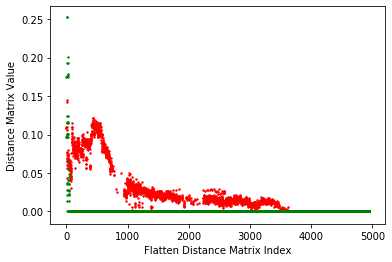

In [11]:
plt.scatter(range(X_train_results[train_show_index].shape[0]), X_train_results[train_show_index], c='r', s = 2)
plt.scatter(range(Y_train_flatten[train_show_index].shape[0]), Y_train_flatten[train_show_index], c='g', s = 2)
plt.xlabel ('Flatten Distance Matrix Index')
plt.ylabel ('Distance Matrix Value')

<function matplotlib.pyplot.show(*args, **kw)>

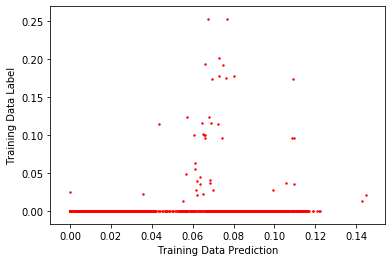

In [13]:
plt.scatter(X_train_results[train_show_index], Y_train_flatten[train_show_index], c='r', s = 2)
plt.xlabel ('Training Data Prediction')
plt.ylabel ('Training Data Label')
plt.show

In [18]:
X_train_results_resh= X_train_results.reshape((1, 24335*4950))
Y_train_resh = Y_train_flatten.reshape((1, 24335*4950))

<function matplotlib.pyplot.show(*args, **kw)>

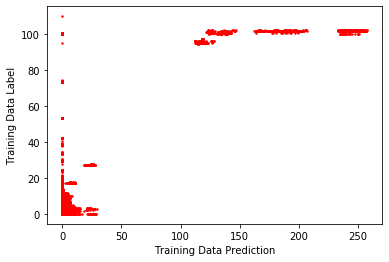

In [19]:
plt.scatter(X_train_results_resh, Y_train_resh, c='r', s = 2)
plt.xlabel ('Training Data Prediction')
plt.ylabel ('Training Data Label')
plt.show

## X_test plot

In [20]:
X_test_results = model.predict(X_test)

In [21]:
test_show_index = 10

Text(0, 0.5, 'Distance Matrix Value')

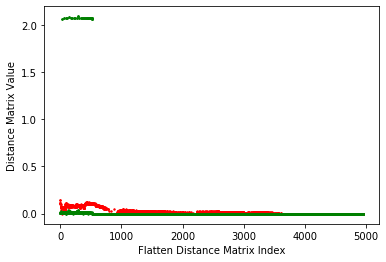

In [23]:
plt.scatter(range(X_test_results[test_show_index].shape[0]), X_test_results[test_show_index], c='r', s = 2)
plt.scatter(range(Y_test_flatten[test_show_index].shape[0]), Y_test_flatten[test_show_index], c='g', s = 2)
plt.xlabel ('Flatten Distance Matrix Index')
plt.ylabel ('Distance Matrix Value')

<function matplotlib.pyplot.show(*args, **kw)>

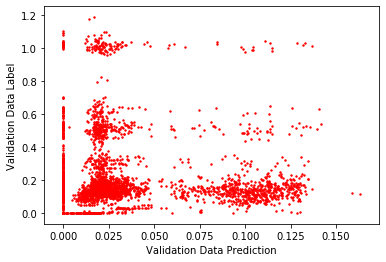

In [26]:
plt.scatter(X_test_results[train_show_index], Y_test_flatten[train_show_index], c='r', s = 2)
plt.xlabel ('Validation Data Prediction')
plt.ylabel ('Validation Data Label')
plt.show

In [30]:
X_test_results_resh= X_test_results.reshape((1, 4295*4950))
Y_test_resh = Y_test_flatten.reshape((1, 4295*4950))

<function matplotlib.pyplot.show(*args, **kw)>

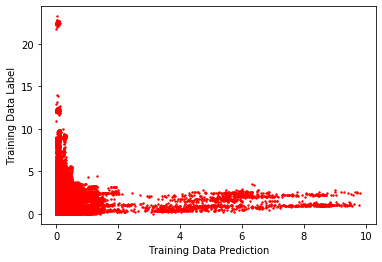

In [31]:
plt.scatter(X_test_results_resh, Y_test_resh, c='r', s = 2)
plt.xlabel ('Training Data Prediction')
plt.ylabel ('Training Data Label')
plt.show

## Plot Loss 

In [32]:
plt.plot(loss_list_epoch)
plt.show()

NameError: name 'loss_list_epoch' is not defined

This is the loss plot for this model. I accidentally rerun the above cell and the output is erased, so I just put the result plot here.

![](https://i.imgur.com/4rqHApM.png)

## Plot RF distance

In [ ]:
for index in range(2):
    index_RF_dist = [each[index] for each in RF_list_distance_epoch]
    plt.plot(index_RF_dist)
    plt.xlabel ('Epochs Index')
    plt.ylabel ('RFR Distance')
    plt.show()

In [ ]:
plt.plot(RF_avg_distance_epoch)
plt.xlabel ('Epochs Index')
plt.ylabel ('RFR Distance')
plt.show()